### Intro to Langevin Dynamics

**This notebook is view-only. You will need to make a copy.**

In this notebook, we will walk through a simple demo for Langevin dynamics, where the goal is to sample from a distribution $\text{p}(x)$ using only its score function $\nabla_x \text{log} \text{p}(x)$. Here we assume a toy setting where $\text{p}(x)$ is known. In most practical cases we only have access a dataset of samples $\mathcal{D} = \{x_0, x_1, \ldots, x_n\} \sim p(x)$, in which case we might use a technique called score matching to estimate the score function [1].

In [1]:
from IPython import display
from functools import partial
import imageio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from tqdm import tqdm

Here we define the log pdf and the gradient of the log pdf (i.e., the score function). We also provide a function for plotting the target shape corresponding for this specific elliptical logpdf.

In [2]:
def logpdf(x, rx=2.5, ry=2.5, cx=0.0, cy=0.0):
    shifted_x = x - torch.tensor([cx, cy])
    scaled_x = shifted_x / torch.tensor([rx, ry])
    r = torch.linalg.norm(scaled_x, axis=-1)
    return -(r - 1)**2 / 0.033

def create_grad_func(logpdf, **kwargs):
  def grad_logpdf(x):
    x.requires_grad_(True)
    log_prob = logpdf(x, **kwargs)
    return torch.autograd.grad(log_prob.sum(), x)[0]
  return grad_logpdf

def create_shape(rx=2.5, ry=2.5, cx=0.0, cy=0.0):
  return  {
      "class": "Ellipse",
      "kwargs": {
          "width": 2 * rx,
          "height": 2 * ry,
          "xy": (cx, cy)
      }
  }

Here we define some utility functions for visualizing results.

In [3]:
def plot_frame(particles, step, shape, figsize=(4, 4), lim=(-3, 3)):
    particles_np = particles.detach().cpu().numpy()
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(particles_np[step, :, 0], particles_np[step, :, 1], alpha=0.1, s=1, color='blue')
    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.set_xlabel("x coord")
    ax.set_ylabel("y coord")
    ax.set_aspect('equal')
    ax.set_title(f'Langevin Sampler at t={step}')

    shape_cls = shape["class"]
    shape_patch = getattr(matplotlib.patches, shape_cls)(
        edgecolor='red',
        facecolor='none',
        linewidth=2,
        **shape["kwargs"]
    )
    ax.add_patch(shape_patch)

    fig.canvas.draw()
    buf = fig.canvas.buffer_rgba()
    image = np.asarray(buf)

    plt.close()
    return image

def plot_trajectory(particles, particle_idx, axis_names=["x", "y"], figsize=(10, 3), lim=(-3, 3)):
    particles_np = particles.detach().cpu().numpy()
    fig, ax = plt.subplots(1, len(axis_names), figsize=figsize)
    for axis, axis_name in enumerate(axis_names):
        trajectory = particles_np[:, particle_idx, axis]
        ax[axis].plot(trajectory)
        ax[axis].set_ylim(*lim)
        ax[axis].set_title(f"Trajectory of particle {particle_idx} along {axis_name}-axis")
        ax[axis].set_xlabel("timestep")
        ax[axis].set_ylabel(f"{axis_names[axis]} coord")

def frames_to_image(frames):
  w, h = frames[0].shape[1], frames[0].shape[0]
  collated = Image.new('RGB', (w * len(frames), h))
  for i, frame in enumerate(frames):
      collated.paste(Image.fromarray(frame), (i * w, 0))
  return collated

def frames_to_gif(frames, filename="temp.gif"):
  imageio.mimsave(filename, frames, fps=5, loop=0)
  return filename

### Part (a)

**Finish the implementation of `langevin_update` and `sample_langevin`.**

Recall that the update equation at timestep $t$ with step size $\eta$ and random noise $\epsilon \sim \mathcal{N}(0,I)$ is

$x_{t+1} = x_t + \eta\nabla_x \log p(x) + \sqrt{2\eta}\epsilon$

In [5]:
def langevin_update(grad_func, current_particles, noise, eta):
    """
    Runs a single Langevin update step on current_particles.
    Returns a tensor of shape (num_particles, 2).
    """
    next_particles = None
    ### start langevin_update ###
    # Compute the gradient of log p(x) at the current_particles
    grad = grad_func(current_particles)
    # Perform the Langevin update step
    next_particles = current_particles + eta * grad + torch.sqrt(2 * eta) * noise
    ### end langevin_update ###
    return next_particles

def sample_langevin(grad_func, particles, num_steps, eta):
    """
    Takes randomly initialized particles and runs them through a Langevin sampler.
    Returns a tensor of shape (num_steps, num_particles, 2).
    """
    particles_over_time = [particles]
    ### start sample_langevin ###
    current_particles = particles

    for step in range(num_steps):
        # Generate noise for each particle
        noise = torch.randn_like(current_particles)  # Same shape as current_particles
        # Update particles using Langevin dynamics
        current_particles = langevin_update(grad_func, current_particles, noise, eta)
        particles_over_time.append(current_particles)
    ### end sample_langevin ###
    particles_over_time = torch.stack(particles_over_time)
    return particles_over_time

Now that you've completed your implementation, run the sampler and visualize results!

For Langevin sampling, you can control the number of particles (`num_particles`), the dimension of each particle (`num_dims`), the number of update steps (`num_steps`), and the step size (`eta`). You can also control the shape of the base logpdf, e.g. the radii of the x and y axes of the ellipse (`rx` and `ry`) and the center (`cx` and `cy`).

In [9]:
def sample_and_viz_langevin(device, langevin_kwargs, ellipse_kwargs, init_particles=None):
  if init_particles is None:
    # Initialize particles
    init_particles = torch.randn(
        langevin_kwargs["num_particles"],
        langevin_kwargs["num_dims"],
        device=device
    )
  # Run langevin sampling
  data = sample_langevin(
      create_grad_func(logpdf, **ellipse_kwargs),
      init_particles,
      langevin_kwargs["num_steps"],
      langevin_kwargs["eta"]
  )
  # Plot results
  frames = []
  for t in tqdm(range(data.shape[0])):
    frames.append(plot_frame(data, t, create_shape(**ellipse_kwargs)))
  return frames

### Part (b)

First, run sampling with the default hyperparameters.

*Note:* To simplify the runtime and plotting, throughout this problem you will only run the Langevin sampler for a few iterations. In practice, however, you would typically run the sampler for longer (e.g., several thousand iterations), to ensure the Markov chain has converged.

100%|██████████| 11/11 [00:01<00:00,  7.42it/s]


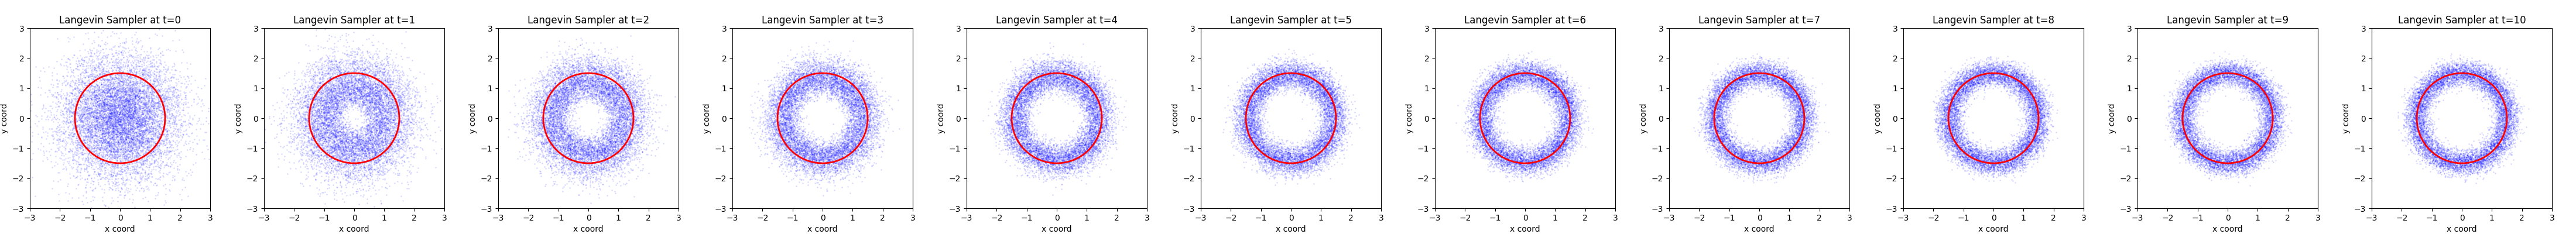

In [8]:
device = "cpu"
langevin_kwargs = {
    "num_particles": 10000,
    "num_dims": 2,
    "num_steps": 10,
    "eta": torch.tensor([1e-2, 1e-2])
}
ellipse_kwargs = {
    "rx": 1.5,
    "ry": 1.5,
    "cx": 0.0,
    "cy": 0.0
}

frames = sample_and_viz_langevin(device, langevin_kwargs, ellipse_kwargs)
frames_to_image(frames)

### Part (c)

Now let's adjust the radius of the elliptical logpdf.

100%|██████████| 11/11 [00:01<00:00,  6.62it/s]


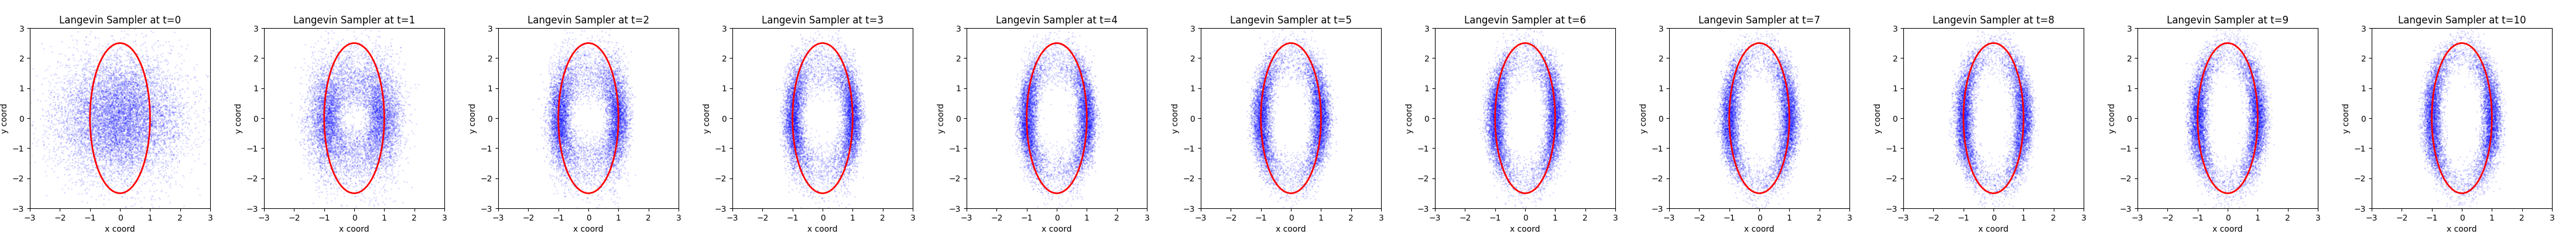

In [10]:
device = "cpu"
langevin_kwargs = {
    "num_particles": 10000,
    "num_dims": 2,
    "num_steps": 10,
    "eta": torch.tensor([1e-2, 1e-2])
}
ellipse_kwargs = {
    "rx": 1.0,
    "ry": 2.5,
    "cx": 0.0,
    "cy": 0.0
}

frames = sample_and_viz_langevin(device, langevin_kwargs, ellipse_kwargs)
frames_to_image(frames)

### Part (d)

Let's see if we can get a better fit to the elliptical logpdf in (c) by tuning each dimension of `eta`.

100%|██████████| 11/11 [00:01<00:00,  7.38it/s]


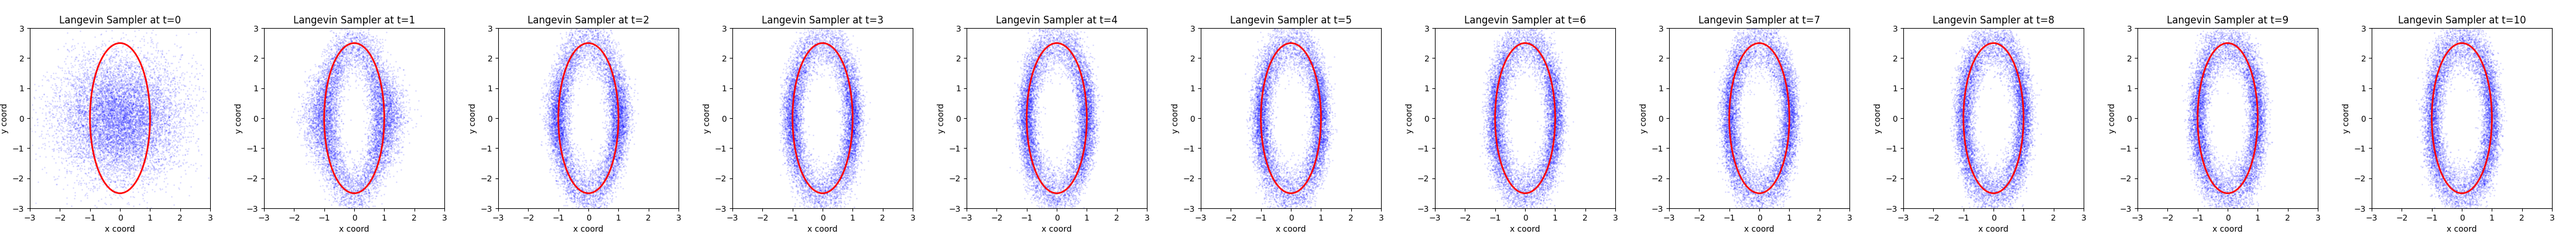

In [26]:
eta = None
### start adjust eta ###
eta = torch.tensor([1e-2, 100e-3])
### end adjust eta ###

device = "cpu"
langevin_kwargs = {
    "num_particles": 10000,
    "num_dims": 2,
    "num_steps": 10,
    "eta": eta
}
ellipse_kwargs = {
    "rx": 1.0,
    "ry": 2.5,
    "cx": 0.0,
    "cy": 0.0
}

frames = sample_and_viz_langevin(device, langevin_kwargs, ellipse_kwargs)
frames_to_image(frames)

### Part (e)

Here let's move the center of the logpdf away from the origin.

100%|██████████| 11/11 [00:01<00:00,  8.58it/s]


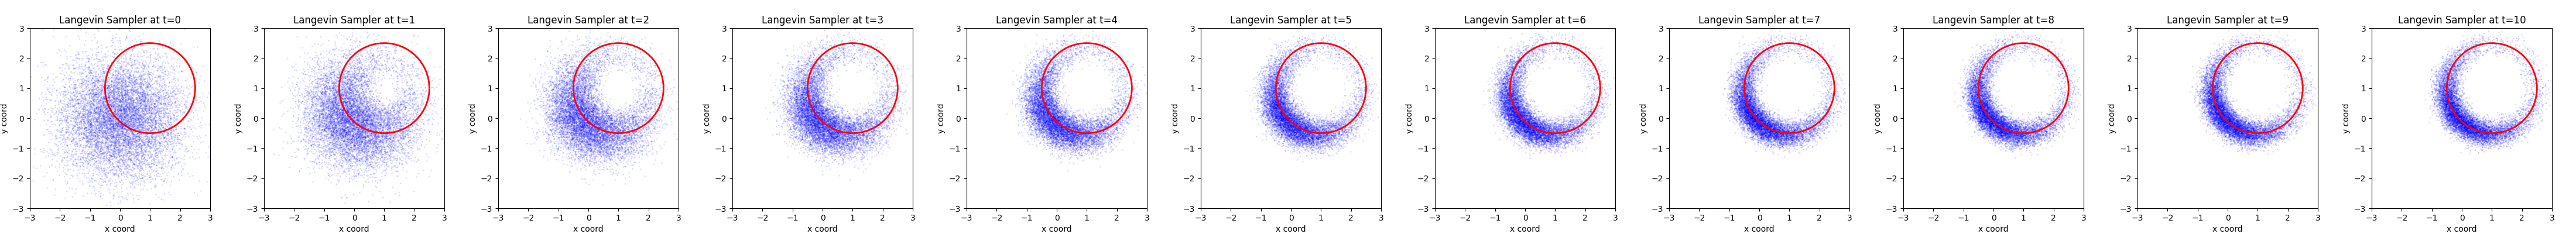

In [27]:
device = "cpu"
langevin_kwargs = {
    "num_particles": 10000,
    "num_dims": 2,
    "num_steps": 10,
    "eta": torch.tensor([1e-2, 1e-2])
}
ellipse_kwargs = {
    "rx": 1.5,
    "ry": 1.5,
    "cx": 1.0,
    "cy": 1.0
}

frames = sample_and_viz_langevin(device, langevin_kwargs, ellipse_kwargs)
frames_to_image(frames)

### Part (f)

For the off-centered logpdf in (e), let's try to get a better fit by tuning the initialization `init_particles`.

100%|██████████| 11/11 [00:01<00:00,  8.95it/s]


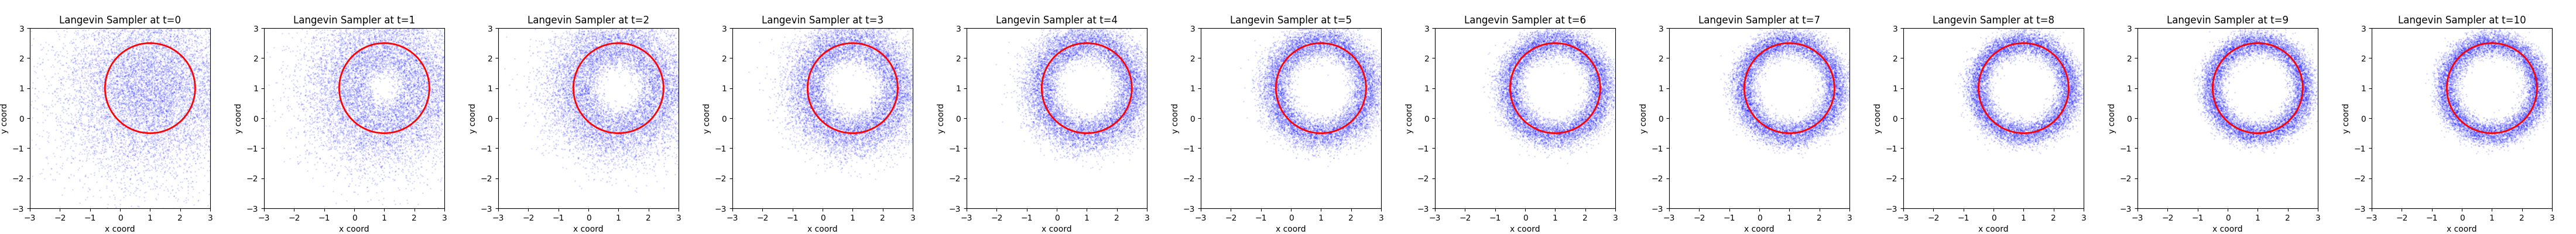

In [30]:
init_particles = None
### start adjust init_particles ###
init_particles = torch.randn((langevin_kwargs["num_particles"], langevin_kwargs["num_dims"])) * torch.tensor([1.5, 1.5]) + torch.tensor([1.0, 1.0])
### end adjust init_particles ###

device = "cpu"
langevin_kwargs = {
    "num_particles": 10000,
    "num_dims": 2,
    "num_steps": 10,
    "eta": torch.tensor([1e-2, 1e-2])
}
ellipse_kwargs = {
    "rx": 1.5,
    "ry": 1.5,
    "cx": 1.0,
    "cy": 1.0
}

frames = sample_and_viz_langevin(device, langevin_kwargs, ellipse_kwargs, init_particles=init_particles)
frames_to_image(frames)

### Conclusion

That's it! Congratulations on finishing the notebook.

**Contributors**

Grace Luo, Saeed Saremi

**Acknowledgements**

This demo is based on Shreyas Kapur's blog post.

**References**

[1] Yang Song and Stefano Ermon. Generative modeling by estimating gradients of the data distribution. NeurIPS 2019.

[2] Shreyas Kapur. Code Focused Guide on Score-Based Image Models. Blog Post 2023.

[3] Yang Song. Generative Modeling by Estimating Gradients of the Data Distribution. Blog Post. Blog Post 2021.